In [1]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
from importlib import reload

import VarConv
import Utils_cifar
reload(VarConv)
reload(Utils_cifar)
VarConvNet = VarConv.VarConvNet
ConvNet = VarConv.ConvNet

In [2]:
epoch_num = 50
batch_size = 32
learning_rate = 0.001
num_workers = 4
start_num = 1
lambda_sample_num = 5
path_to_save = 'saved_cifar_new'
init_log_sigma = -5.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0
lambda_encode = lambda x: (x-1e-3)/(10.0-1e-3)
lamb = [ 0.001, 0.01, 0.1, 1.0, 10.0]
    
if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

In [3]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = t.utils.data.DataLoader(cifar_trainset, batch_size=batch_size,shuffle=True, num_workers=num_workers)

cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = t.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def test_acc_train(net): # точность классификации
    acc = []    
    net.eval()
    lamb =  [ 0.001, 0.01, 0.1, 1.0, 10.0]
    for l in lamb:
        correct = 0
        for x,y in test_loader: 
            x = x.to(device)
            y = y.to(device)
            #out = net(x[:,0].view(-1, 32*32)) 
            out = net(x,lambda_encode(t.tensor(l)))    
            correct += out.argmax(1).eq(y).sum().cpu().numpy()
            t.cuda.empty_cache()
        acc.append(correct / len(cifar_testset))
        t.cuda.empty_cache()
    net.train()
    return acc

In [6]:
def test_acc_prune(net): # точность классификации
    acc = []    
    net.eval()
    correct = 0
    for x,y in test_loader: 
        x = x.to(device)
        y = y.to(device)
        out = net(x)    
        correct += out.argmax(1).eq(y).sum().cpu().numpy()
        t.cuda.empty_cache()
    acc.append(correct / len(cifar_testset))
    t.cuda.empty_cache()
    net.train()
    return acc

In [7]:
def train_batches(net, loss_fn, optimizer, lam, label, e):
    tq = tqdm.tqdm(train_loader)
    losses = []
    for x,y in tq:            
        x = x.to(device)
        y = y.to(device)          
        optimizer.zero_grad()  
        loss = 0
        if lam is None:
            
            for _ in range(lambda_sample_num):  
                p = t.rand(1).to(device)*4 -3
                #p =  t.rand(1) * 2 - 1
                lam_param = 10**p[0]
                
                #lam_param = t.tensor(1.0)
                #t.rand(1).to(device)[0]*100.0                  
                out = net(x, lambda_encode(lam_param))
                #out = net(x)
                loss = loss + loss_fn(out, y)/lambda_sample_num
                loss += net.KLD(lambda_encode(lam_param))*lam_param/len(cifar_trainset)/lambda_sample_num
                #loss += net.KLD(lam_param)*t.log(lam_param)/len(trainset)/lambda_sample_num
                losses+=[loss.cpu().detach().numpy()]    
                t.cuda.empty_cache()
                
        tq.set_description(label+str(np.mean(losses)))
       
        loss.backward()       
      
        clip_grad_value_(net.parameters(), 1.0) # для стабильности градиента. С этим можно играться
        #print (losses)
        
        optimizer.step()
        
        #lr_scheduler.step()
    acc = test_acc(net)
    print (acc)
    return acc

In [ ]:
t.manual_seed(0)
for start in range(start_num): 
    
    net = VarConvNet(init_log_sigma, prior_sigma)
    
    net.to(device)
   
    optim = t.optim.Adam(net.parameters())
    
    #lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=milestones, gamma=0.5)
    loss_fn = nn.CrossEntropyLoss().to(device) 
    for e in range(epoch_num):
        label = 'CIFAR, epoch {}: '.format(e)                
        acc = train_batches(net, loss_fn, optim, None, label, e )
        with open('acc.log', 'a') as out:
            out.write('{}:{}\n'.format(e, acc))
        t.save(net.state_dict(), os.path.join(path_to_save, 'cifar_epoch_{}.cpk'.format( e)))
    t.save(net.state_dict(), os.path.join(path_to_save, 'cifar_start_{}.cpk'.format( start)))

In [9]:
net = ConvNet().to(device)
hnet = VarConvNet(init_log_sigma, prior_sigma).to(device)

lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num): 
        print(lam, s)
        hnet.load_state_dict(t.load(os.path.join(path_to_save, 'cifar_start_{}.cpk'.format(s))))        
        Utils_cifar.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam))
        lam_results[lam].append(Utils_cifar.delete_10(net, device, lambda:test_acc_prune(net)))
import json
with open(os.path.join(path_to_save, 'results_cifar.json'),'w') as out:
    out.write(json.dumps(lam_results))        

0.001 0
0.01 0
0.1 0
1.0 0
10.0 0


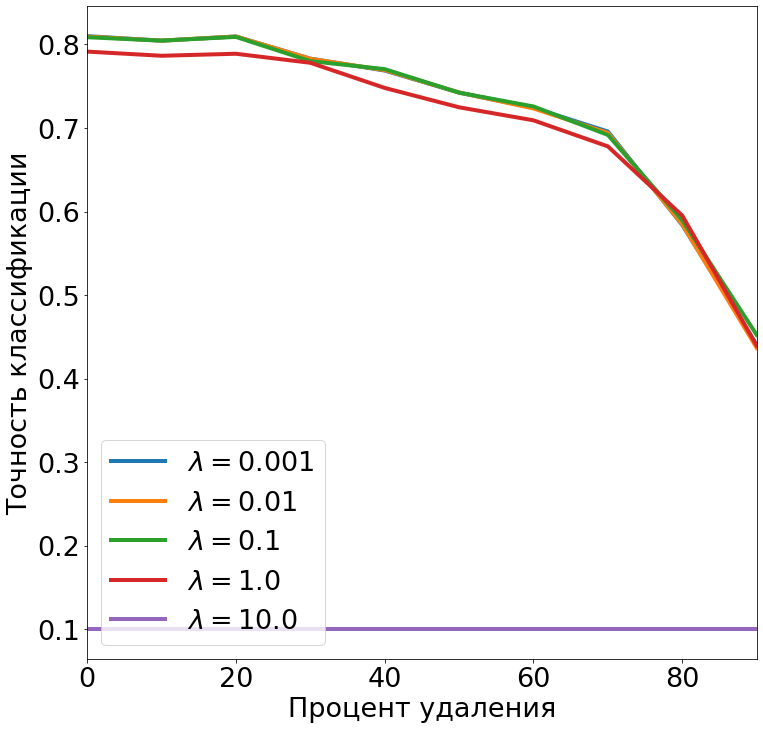

In [10]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    #plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Cifar_pruning.png')